## initial installation
### start with environment from class

> %pip install h5py
%pip install keras
%pip install --upgrade tensorflow
%pip install sklearn
%pip install seaborn
%pip install pydot
%pip install pydot graphviz     # for plotting model
%pip install librosa
%pip show tensorflow

#TODO write requirements.txt to include all of these

In [1]:
import numpy as np
import h5py
import os, re, glob
import math
from scipy import signal
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from tensorflow.keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import SGD, Adam, schedules

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, CSVLogger
from tensorflow.keras.initializers import VarianceScaling

sns.set_style('darkgrid')
sns.set_palette('muted')

sns.set_style('darkgrid')
sns.set_palette('muted')

2024-11-14 20:02:54.158211: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 20:02:54.450238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 20:02:54.614218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 20:02:54.662122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 20:02:54.908392: I tensorflow/core/platform/cpu_feature_guar

### Optional - LFS

<div style="font-size: 14px;">
Input.npy is a Git LFS (Large File Storage) pointer to a large data file.

To download the file:

1. Install Git LFS (if you haven't already) AND you're on a system where you have sudo access
    ```python
    sudo apt-get install git-lfs
    ```
2. Initialize Git LFS in your repo (if you haven't already)
    ```python
    git lfs install
    ```
3. Track .npy Files with Git LFS
    ```python
    git lfs track "*.npy"
    ```

After you have cloned the repo, download the data file:

`    git lfs pull`


Note that the file is about 230MB. Running this locally will take a while. Using memory-map will save some time:

> The mmap_mode parameter in NumPy's np.load function allows you to memory-map a file, which means that the file is not fully loaded into memory. Instead, it is mapped to a portion of the virtual memory, allowing you to access parts of the file on demand. This is particularly useful for working with large files that do not fit into memory.
</div>

# Load data and split train-test

In [2]:
# download data from https://geofon.gfz-potsdam.de/doi/network/9F/2021

from sklearn.model_selection import train_test_split

print("beginning to load file...")

# memory-map the file, which is read-only by default
data_file = np.load("Input_nuph.npy", mmap_mode='r') # Seismic data from station NUPH should be cited as: doi:10.14470/4S7576570845

# show the shape of the data_file
print("shape of data_file: ", data_file.shape)


print("file loaded")

print("split data into training and testing sets")
train, test= train_test_split (data_file, test_size=0.2, train_size=0.8, random_state=46, shuffle=True)

print ('size-data_file='+str (data_file.shape), 'size-train='+str (train.shape),'size-test='+str (test.shape) )

beginning to load file...
shape of data_file:  (2542, 96, 128)
file loaded
split data into training and testing sets
size-data_file=(2542, 96, 128) size-train=(2033, 96, 128) size-test=(509, 96, 128)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


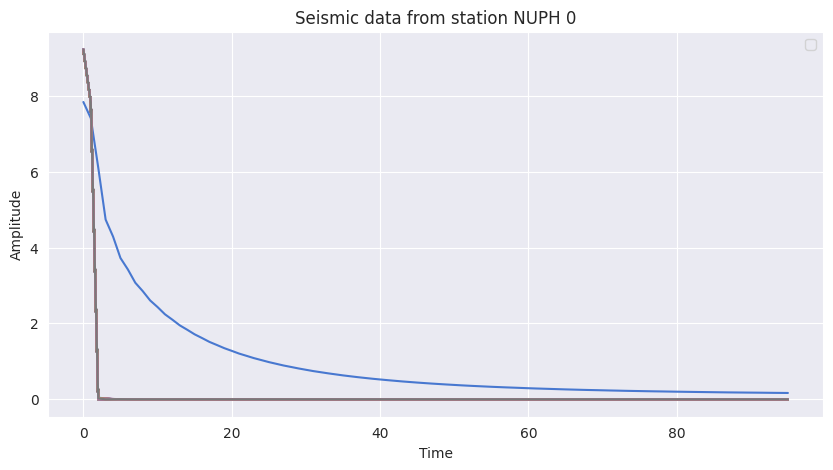

[[[7.83752539e+00 9.20004241e+00 9.20426768e+00 ... 9.21333375e+00
   9.22728816e+00 9.22399441e+00]
  [7.41205875e+00 7.81332269e+00 7.81820696e+00 ... 7.82498952e+00
   7.84237064e+00 7.83971966e+00]
  [6.11368390e+00 1.26663657e-02 2.97486213e-03 ... 5.69995945e-03
   1.70691707e-04 1.67433787e-02]
  ...
  [1.68196113e-01 8.06303496e-08 5.20859463e-06 ... 7.69709575e-08
   3.80402398e-07 1.32762509e-06]
  [1.66510693e-01 3.02190558e-07 3.26951000e-06 ... 5.91177288e-07
   1.48755492e-07 3.66392323e-07]
  [1.64965876e-01 2.03262883e-08 5.12075428e-07 ... 1.62137542e-06
   6.41217927e-09 8.88124554e-07]]

 [[8.30300983e+00 9.67911231e+00 9.67784660e+00 ... 9.66492956e+00
   9.66417109e+00 9.66648199e+00]
  [7.87658711e+00 8.29407255e+00 8.29201273e+00 ... 8.27915709e+00
   8.27593184e+00 8.28396094e+00]
  [6.57504450e+00 5.37819344e-04 1.86735121e-03 ... 3.65497888e-04
   3.42954818e-02 3.48929854e-02]
  ...
  [2.58917906e-01 1.43611774e-07 2.77857009e-06 ... 7.70747628e-07
   3.65381

In [3]:
# display some of the data in Input.npy
for i in range(1):
    plt.figure(figsize=(10, 5))
    plt.plot(data_file[i])
    plt.title('Seismic data from station NUPH ' + str(i))
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    # Assuming 'y' contains the labels for the data
    plt.legend()
    plt.show()
    
# show the top 10 rows
print(data_file[:3])

# display number of dimensions of data_file
print(f'Number of dimensions:', data_file.ndim)



# Autoencoder architecture construction

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 64, 8)      │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 32, 16)     │         1,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 16, 32)     │         7,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 8, 64)       │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │        73,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3072)           │        76,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 12, 16, 32)     │        30,752 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 24, 32, 16)     │         7,696 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 48, 64, 8)      │         1,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 96, 128, 1)     │           281 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,929 (905.97 KB)

 Trainable params: 231,929 (905.97 KB)

 Non-trainable params: 0 (0.00 B)

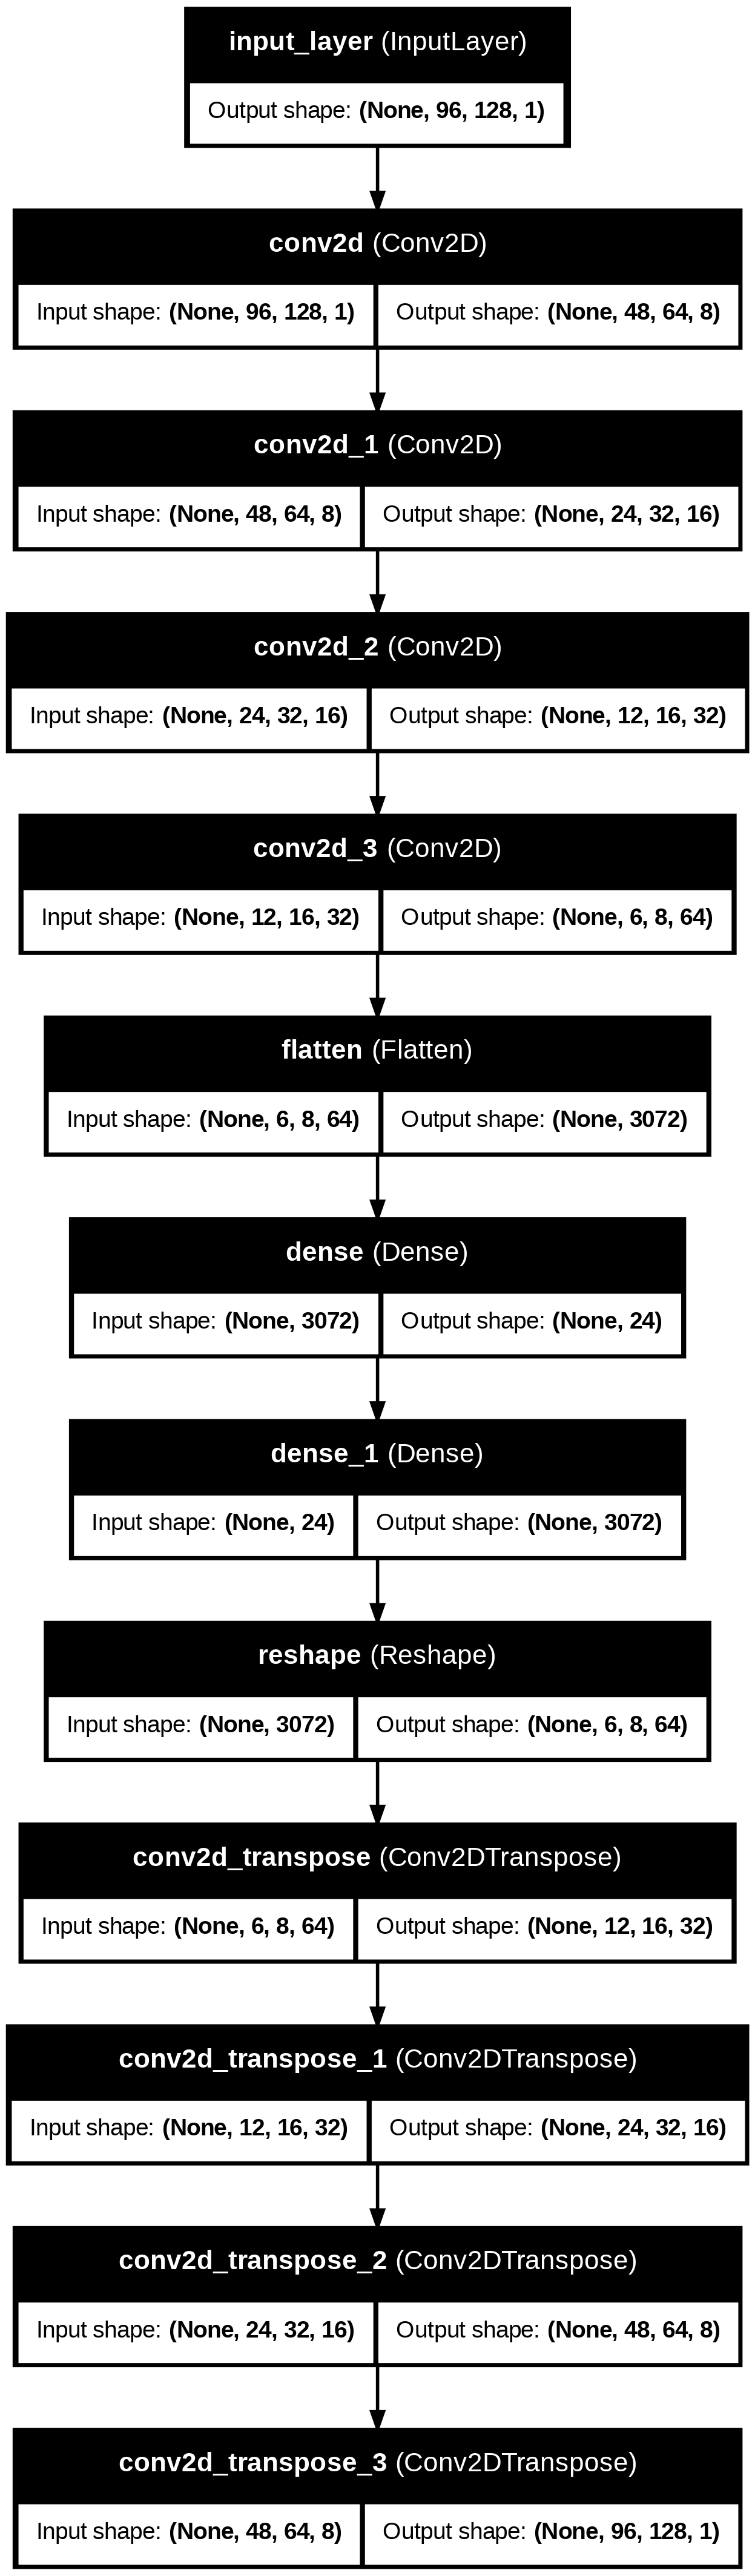

In [4]:
from numpy.random import seed
sd=46
seed(sd)
#import tensorflow
import tensorflow as tf
tf.random.set_seed(sd)

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten, Reshape
from tensorflow.keras.models import Model
# import tensorflow as tf
import tensorflow.keras.backend as K 

initializer = tf.keras.initializers.GlorotUniform(seed=sd)

inp = Input(shape=(96, 128, 1))  
e = Conv2D(8, (7, 5),strides=[2,2], activation='elu', kernel_initializer=initializer, padding='same')(inp)
e = Conv2D(16, (5, 3),strides=[2,2], activation='elu', kernel_initializer=initializer, padding='same')(e)
e = Conv2D(32, (5, 3),strides=[2,2], activation='elu', kernel_initializer=initializer, padding='same')(e)
e = Conv2D(64, (5, 3),strides=[2,2], activation='elu' , kernel_initializer=initializer, padding='same')(e)

# use tf.keras.backend.int_shape to get the shape of a tensor
shape_before_flattening = tf.keras.backend.int_shape(e)
encoded1 = Flatten()(e)

encoded2= Dense (24, activation='elu')(encoded1)
fc= Dense (3072, activation='elu')(encoded2)

d = Reshape(shape_before_flattening[1:])(fc)
    
d = Conv2DTranspose(32, (5, 3), strides=[2,2], activation='elu', kernel_initializer=initializer, padding='same')(d)
d = Conv2DTranspose(16, (5, 3), strides=[2,2], activation='elu', kernel_initializer=initializer, padding='same')(d)
d = Conv2DTranspose(8, (5, 3),strides=[2,2] , activation='elu', kernel_initializer=initializer, padding='same')(d)
decoded = Conv2DTranspose(1, (7, 5),strides=[2,2] , activation='linear', kernel_initializer=initializer, padding='same')(d)

autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded2, name='encoder')

# use tf.keras.utils.plot_model to visualize the model
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

autoencoder.summary()

# Specify the full path for the output file
output_path = os.path.join(os.getcwd(), 'autoencoder.png')

#TODO: make this display more interesting
try:
    plot_model(autoencoder, to_file=output_path, show_shapes=True, show_layer_names=True)
    display(Image(filename=output_path, width=800, height=600))
except Exception as e:
    print(f"Error creating or displaying model plot: {e}")

# Initial training phase: Pretraining the autoencoder

In [5]:
# raise number to 500 during actual run
# 50 is faster, so use it for setup
NUM_OF_EPOCHS = 500

lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate= 0.001,
    decay_steps=1000,
    decay_rate=0.5)

### Adapting the learning rate of the optimizer using an exponential decay schedule

optimizer = Adam(learning_rate=lr_schedule)   

# Define the callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
csv_logger = CSVLogger('pretrain_log.csv')
# original lien:
#es = EarlyStopping( monitor='val_loss', mode='min', verbose=1, patience=30), CSVLogger('pretrain_log.csv')

autoencoder.compile(optimizer=optimizer, loss='mse')
autoencoder.fit(train, train, batch_size=32, epochs=NUM_OF_EPOCHS ,validation_data=(test, test), callbacks=[es, csv_logger])

Epoch 1/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.9609 - val_loss: 0.0443
Epoch 2/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0347 - val_loss: 0.0148
Epoch 3/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0139 - val_loss: 0.0098
Epoch 4/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0094 - val_loss: 0.0073
Epoch 5/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0071 - val_loss: 0.0060
Epoch 6/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 7/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 8/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 9/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 10/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 11/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 12/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step

# Evaluate autoencoder reconstruction

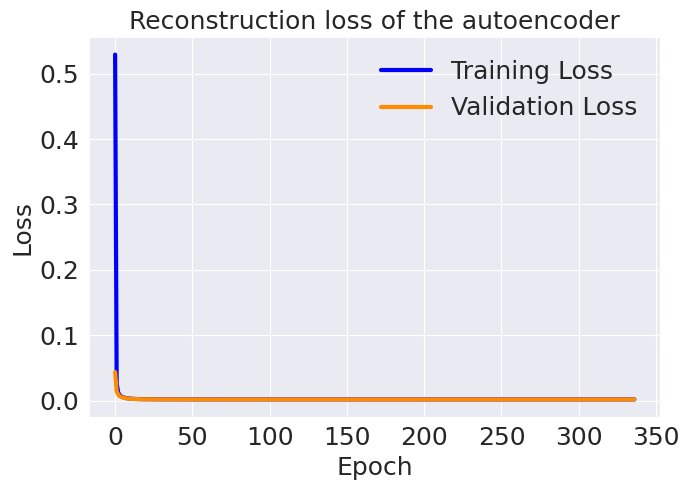

In [6]:
import pandas as pd
df = pd.read_csv('pretrain_log.csv')
fig= plt.figure(figsize=(7, 5))
plt.plot(df['epoch'],df['loss'], color='b',label='Training Loss', linewidth=3.0)
plt.plot(df['epoch'],df['val_loss'], color='darkorange',label='Validation Loss', linewidth=3.0)

plt.ylabel('Loss', fontsize= 18)
plt.xlabel('Epoch', fontsize= 18)
plt.title('Reconstruction loss of the autoencoder', fontsize= 18)
plt.yticks (fontsize= 18)
plt.xticks (fontsize= 18)

plt.legend(loc= 1, frameon= False, fontsize= 18)
plt.tight_layout()
plt.show ()
fig.savefig ( 'ReconstructionLoss.png', dpi= 100)

In [7]:
### Save the model

# original
# autoencoder.save ('autoencoder-model')

autoencoder.save('autoencoder-model.keras')

### Autoencoder input-output visualization

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


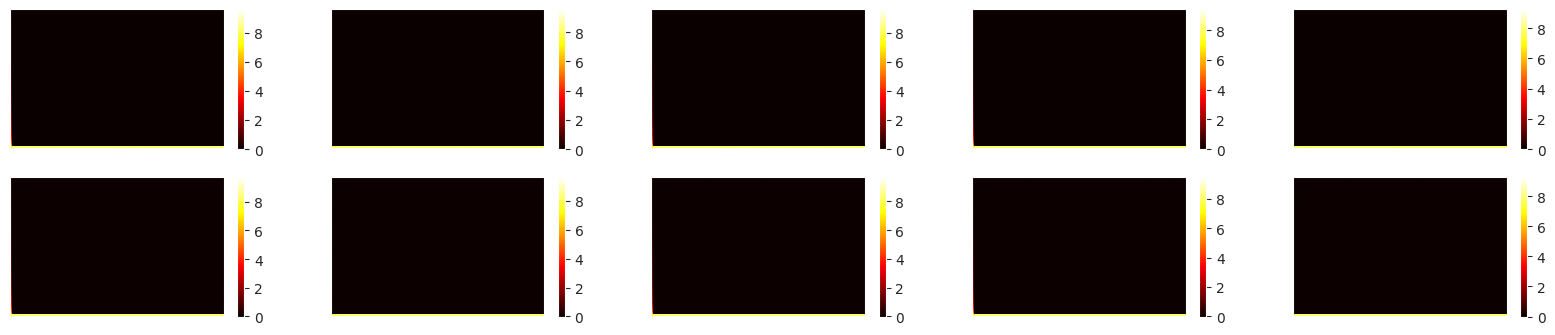

In [8]:
decoded_imgs = autoencoder.predict(data_file)

import librosa
import librosa.display

s=300
e=305
n = e-s

plt.figure(figsize=(20, 4))
for i in range(s,e):
    
    # Display original
    ax = plt.subplot(2, n, i-s + 1)
    librosa.display.specshow(data_file[i,:,:], alpha=None, cmap='hot', antialiased=True)
    plt.colorbar ()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i-s + 1 + n)
    librosa.display.specshow(decoded_imgs[i,:,:,0], alpha=None, cmap='hot', antialiased=True)
    plt.colorbar ()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Kmeans clustering based on extracted features from the autoencoder

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


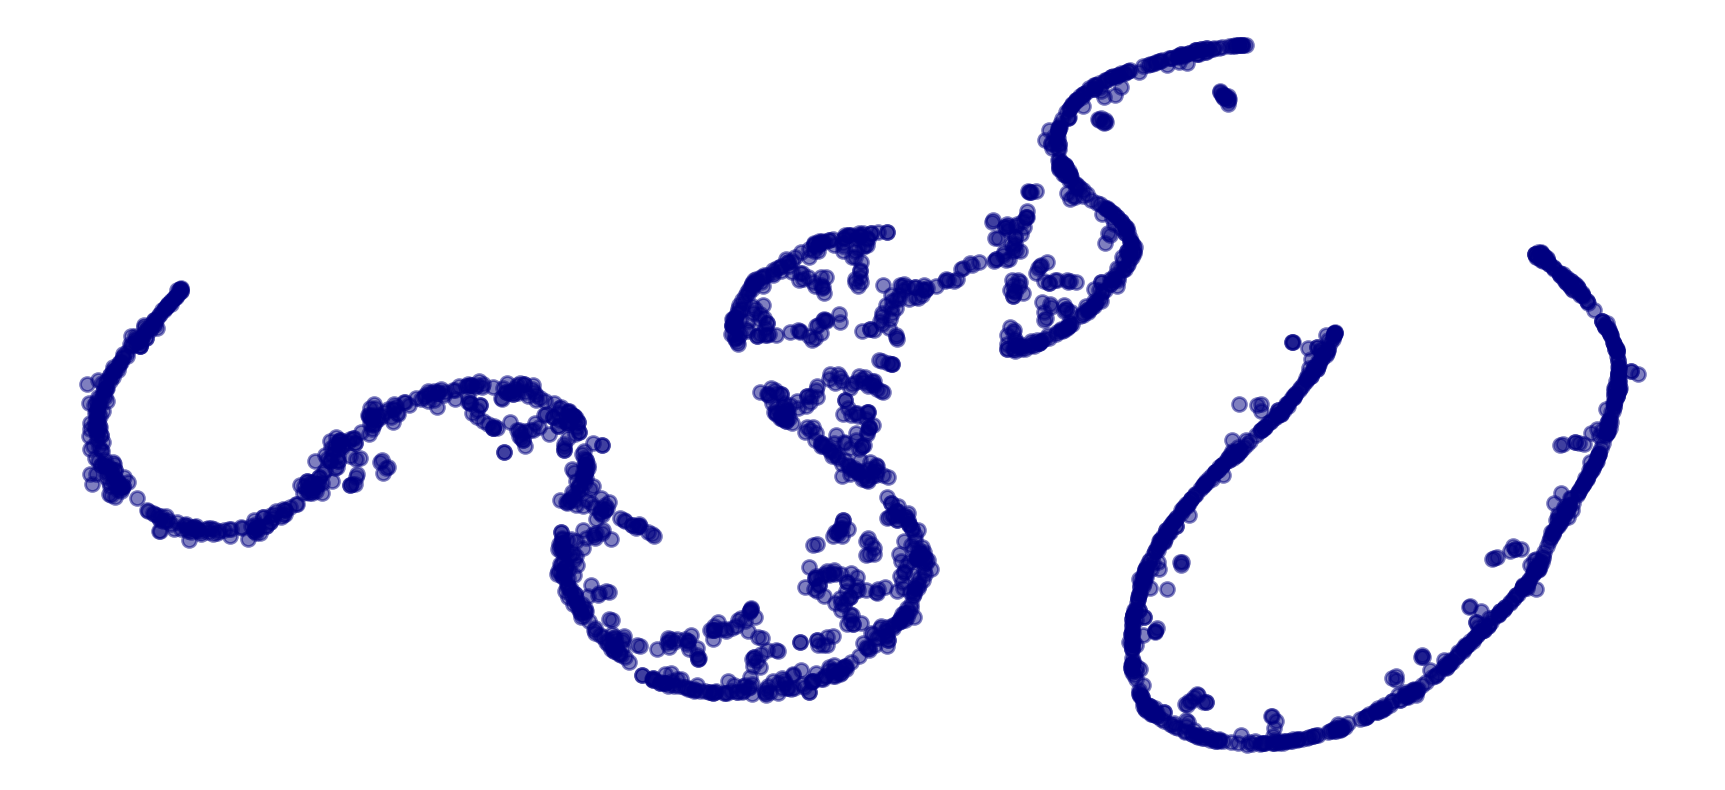

(<Figure size 2200x1000 with 1 Axes>, <Axes: >)

In [9]:
kmeans = KMeans(n_clusters=1, random_state=46, n_init=20).fit(encoder.predict(data_file))
y = kmeans.predict(encoder.predict(data_file))

def plotter(S, y):
    '''
    function to visualize the outputs of t-SNE
    '''
    
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    plt.scatter(S[y == 0, 0], S[y == 0, 1],color='navy', alpha=.5, lw=lw, s=100)
    ax.axis('off')
    ax.axis('tight') 
    plt.show()
    f.savefig ('Tnse-km-n1', dpi= 100,bbox_inches = "tight")

    return f, ax

enc = encoder.predict(data_file)
from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
plotter(redu, y) 


TODO: this plot doesn't look like the paper's plot
This will make the following images look different from the paper.

# Determining optimal number of clusters

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
80/80 ━━━━━━━━━━━━━━━━━━━

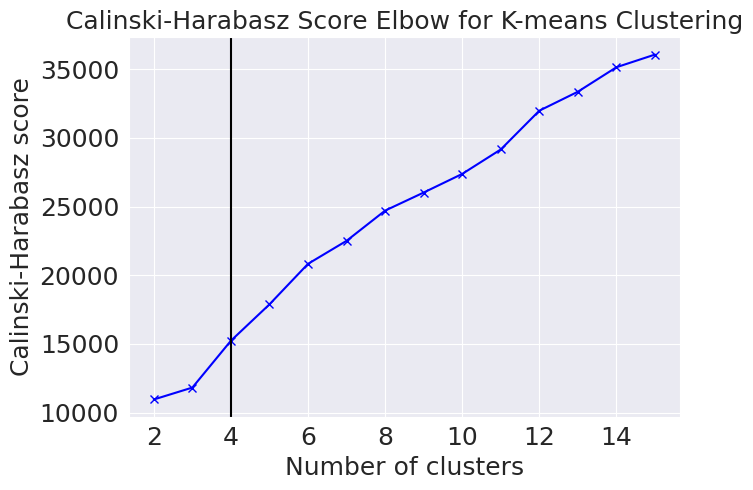

In [10]:
from sklearn.metrics import calinski_harabasz_score
cal = []
K = range(2,16)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20).fit(encoder.predict(data_file))
    labelskm = kmeans.predict(encoder.predict(data_file))
    cal.append(calinski_harabasz_score(encoder.predict(data_file), labelskm))
fig= plt.figure(figsize=(7, 5))
plt.plot(K, cal, 'bx-')
plt.xlabel('Number of clusters',fontsize= 18)
plt.ylabel('Calinski-Harabasz score',fontsize= 18)
plt.title('Calinski-Harabasz Score Elbow for K-means Clustering',fontsize= 18)
plt.yticks (fontsize= 18)
plt.xticks (fontsize= 18)
plt.axvline(x = 4, color = 'black')
plt.tight_layout()
plt.show()
fig.savefig ( 'Calinski score.png', dpi=100)

# T-sne visualizations of seismic event clusters in feature domain after pretraining

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


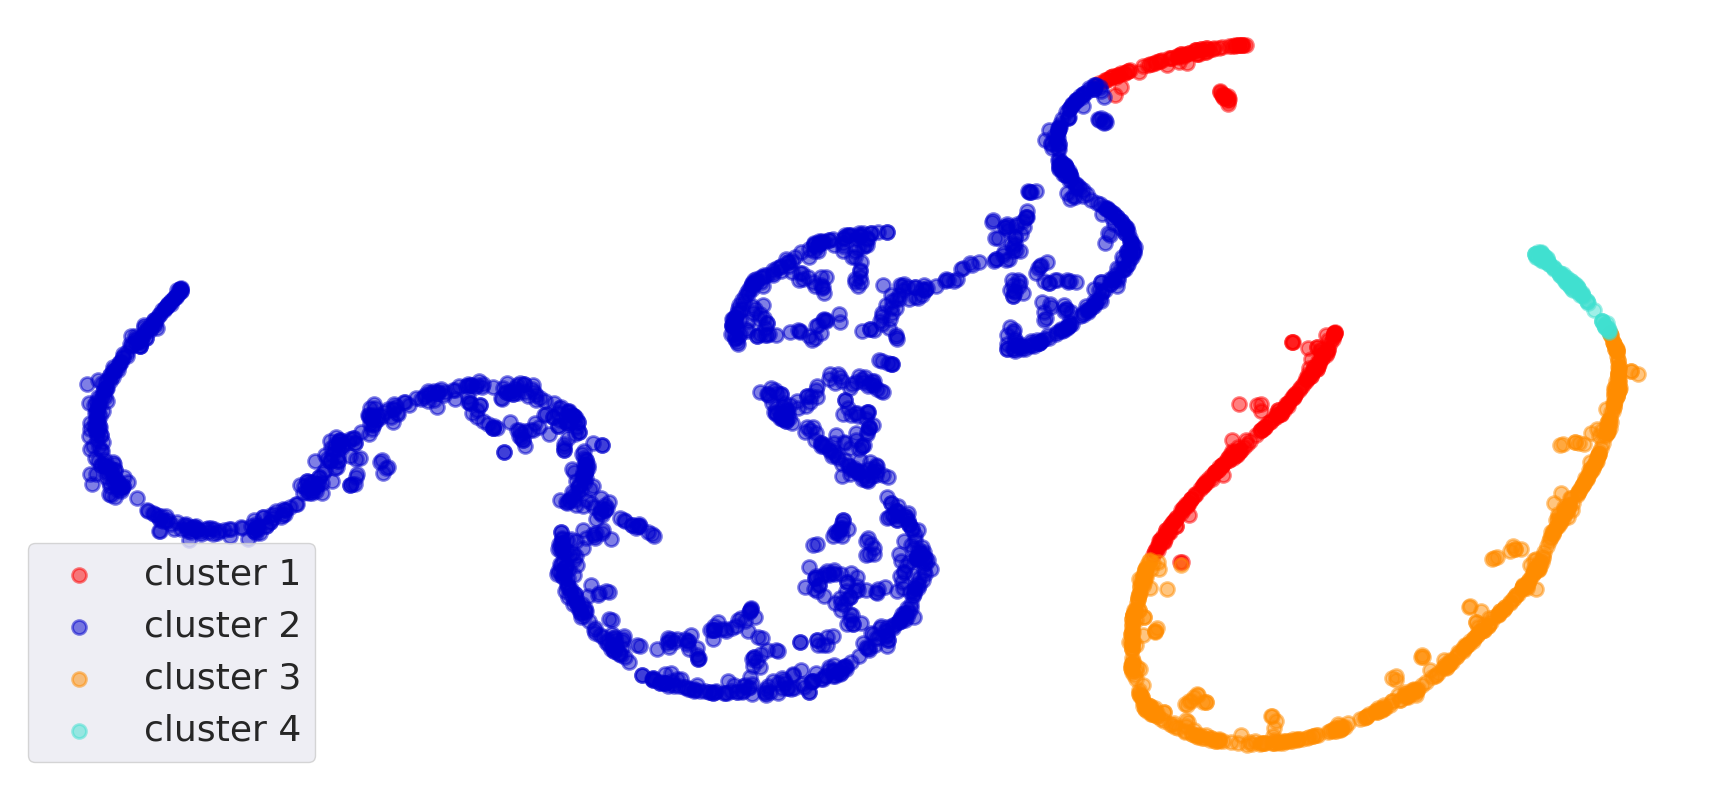

(<Figure size 2200x1000 with 1 Axes>, <Axes: >)

In [11]:
kmeans = KMeans(n_clusters=4, random_state=46, n_init=20).fit(encoder.predict(data_file))
y = kmeans.predict(encoder.predict(data_file))

def plotter(S, y, target_names):
    '''
    function to visualize the outputs of t-SNE
    '''
    # choose a color palette with seaborn.
    colors = [ 'red', 'mediumblue','darkorange','turquoise','lime', 'turquoise', 'darkorange','lawngreen', 'red', 'saddlebrown']
    
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    for color, i, target_name in zip(colors, [3,0, 1,2], target_names):
        plt.scatter(S[y == i, 0], S[y == i, 1], color=color, alpha=.5, lw=lw, s=100, label=target_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 26})
    ax.axis('off')
    ax.axis('tight') 
    plt.show()
    f.savefig ('Tnse-km-n4', dpi= 100,bbox_inches = "tight")

    return f, ax

enc = encoder.predict(data_file)
from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
target_names = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4']
plotter(redu, y, target_names) 


# Loading the pre-trained model

In [12]:
from tensorflow.keras.models import load_model
autoencoder = load_model("autoencoder-model.keras")

In [13]:
import tensorflow as tf

# Assuming autoencoder and data_file are already defined
layer_outputs = [layer.output for layer in autoencoder.layers[1:]]
activation_model = tf.keras.models.Model(inputs=autoencoder.input, outputs=layer_outputs)

# Get the outputs of all layers
layer_output = activation_model.predict(data_file)

# Display the outputs
for i, output in enumerate(layer_output):
    print(f"Layer {i+1} output shape: {output.shape}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Layer 1 output shape: (2542, 48, 64, 8)
Layer 2 output shape: (2542, 24, 32, 16)
Layer 3 output shape: (2542, 12, 16, 32)
Layer 4 output shape: (2542, 6, 8, 64)
Layer 5 output shape: (2542, 3072)
Layer 6 output shape: (2542, 24)
Layer 7 output shape: (2542, 3072)
Layer 8 output shape: (2542, 6, 8, 64)
Layer 9 output shape: (2542, 12, 16, 32)
Layer 10 output shape: (2542, 24, 32, 16)
Layer 11 output shape: (2542, 48, 64, 8)
Layer 12 output shape: (2542, 96, 128, 1)


In [14]:
n_clusters=4

# Integrating clustering layer into autoencoder bottleneck

...Finetuning...


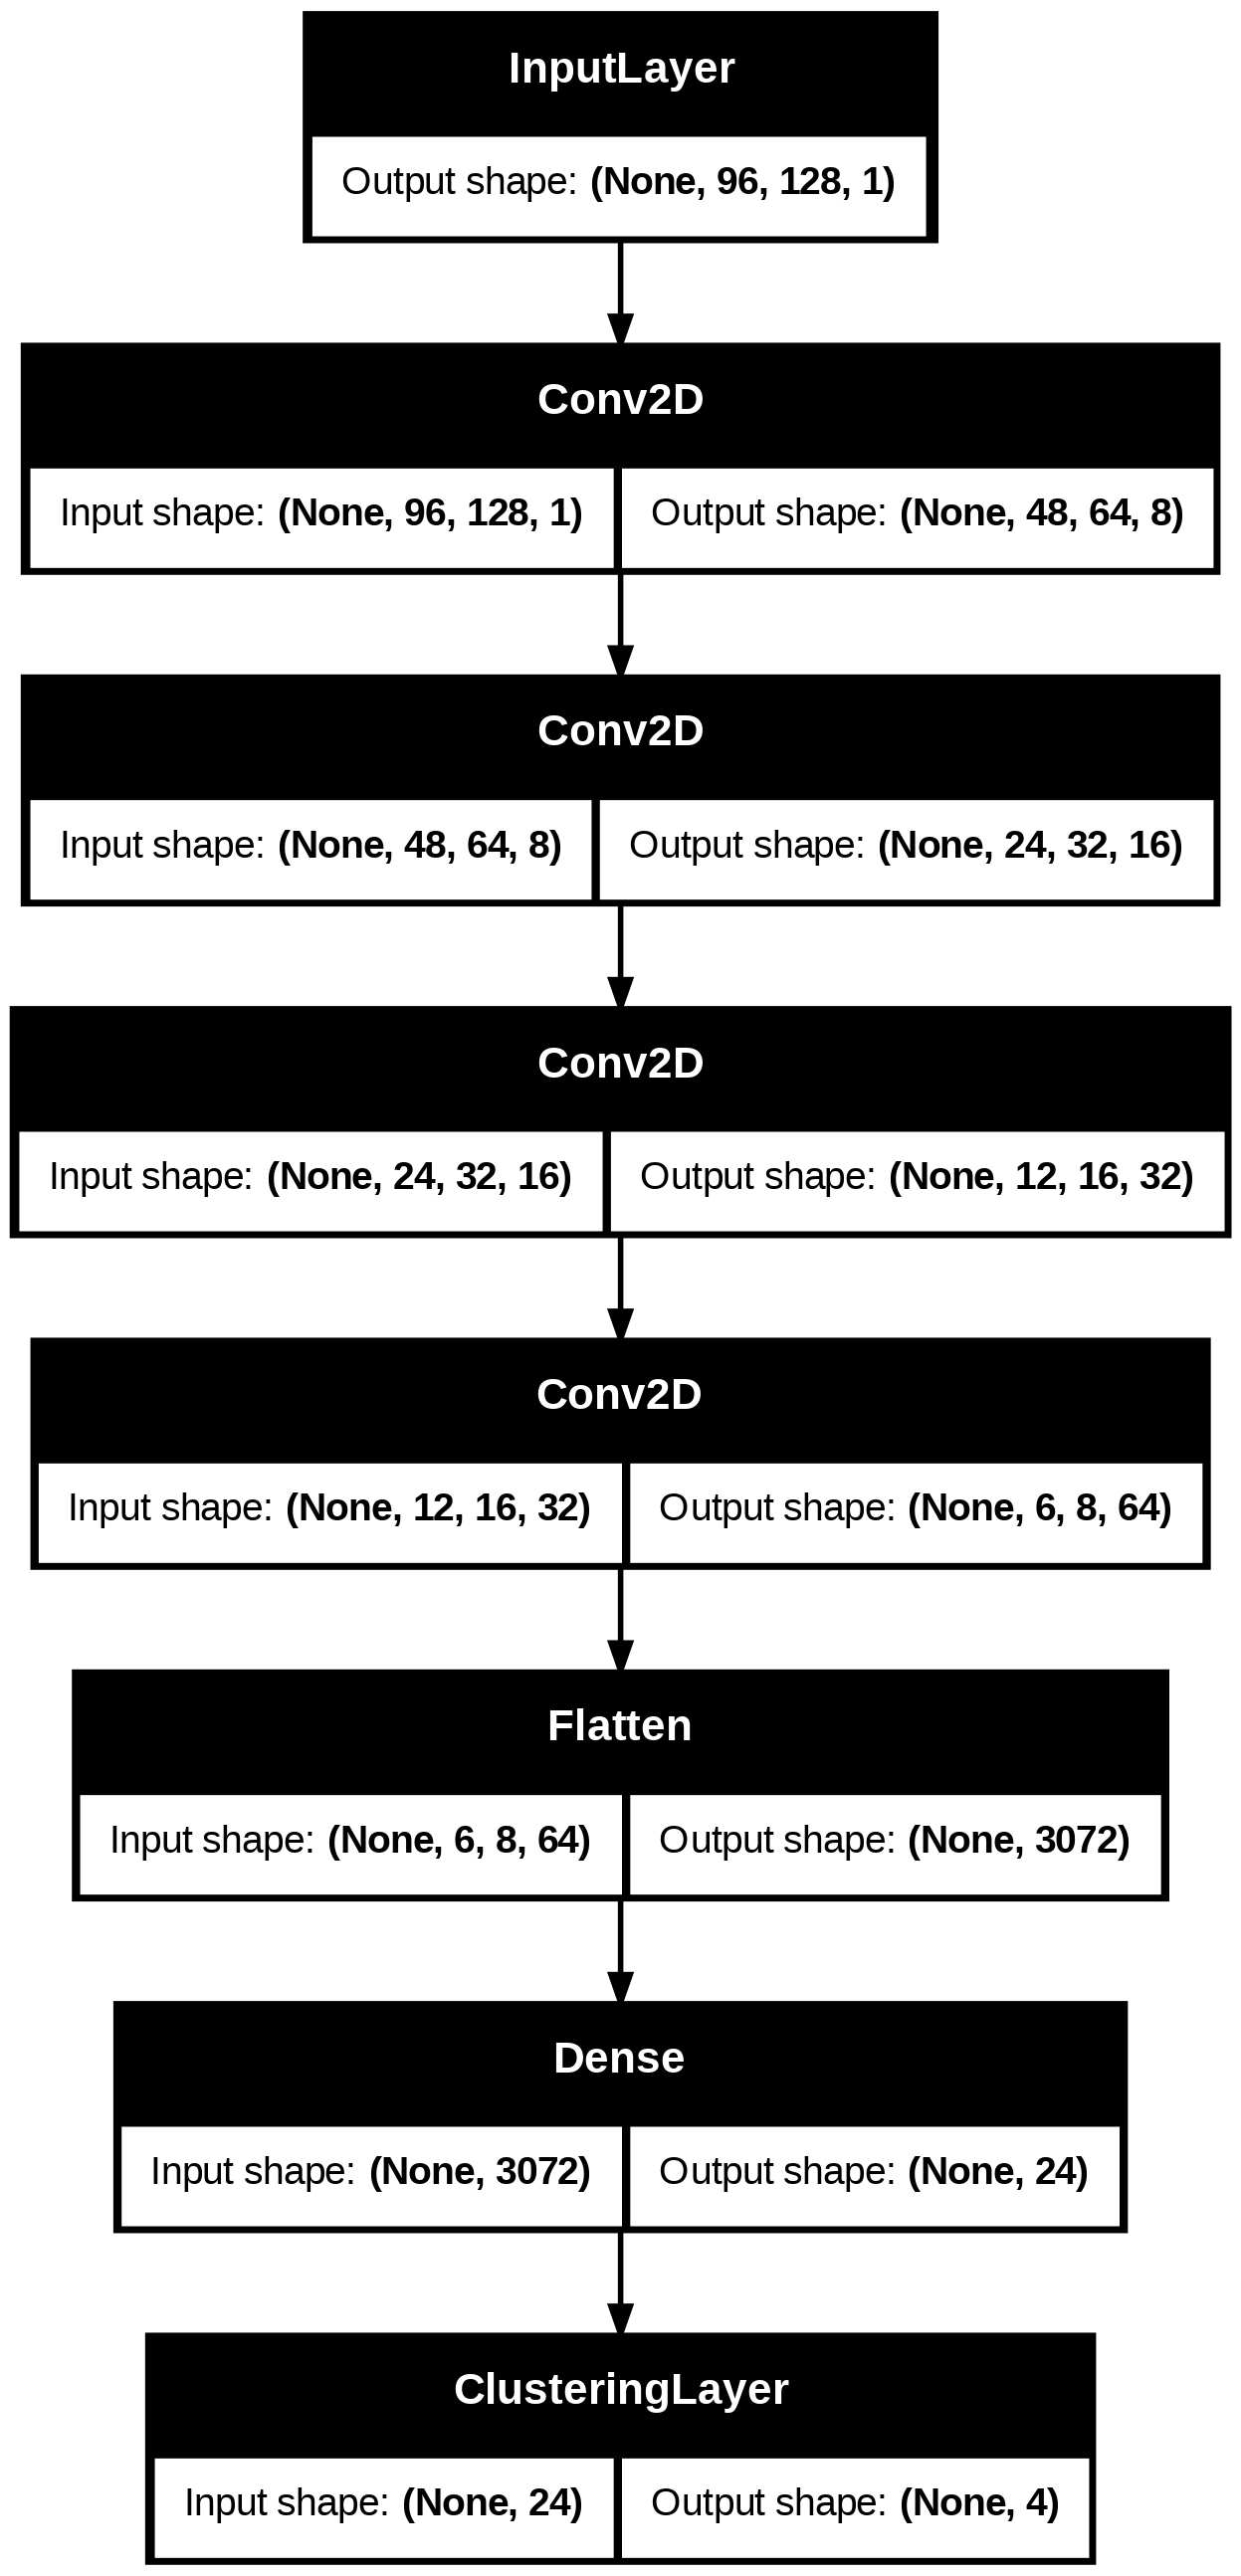

In [15]:
from numpy.random import seed
sd=46
seed(sd)
#import tensorflow
import tensorflow as tf
tf.random.set_seed(sd)

initializer = tf.keras.initializers.GlorotUniform(seed=sd)

#### clustering layers
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=tf.keras.backend.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer= initializer , name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
    
    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (tf.keras.backend.sum(tf.keras.backend.square(tf.keras.backend.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = tf.keras.backend.transpose(tf.keras.backend.transpose(q) / tf.keras.backend.sum(q, axis=1)) 
        return q
    
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


print('...Finetuning...')   

clustering_layer = ClusteringLayer(n_clusters=n_clusters, name='clustering')(autoencoder.layers[6].output)
model = Model(inputs=autoencoder.input, outputs=clustering_layer)
model.compile(loss='kld', loss_weights=0.1, optimizer=SGD(learning_rate=0.01, momentum=0.9))

plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')

# ORIGINAL FROM REPO
# clustering_layer = ClusteringLayer(n_clusters, name='clustering')(autoencoder.layers[6].output)
# model = Model(inputs=autoencoder.layers[0].output, outputs=clustering_layer)
# model.compile(loss='kld', loss_weights=0.1,  optimizer=SGD(learning_rate=0.01,  momentum=0.9))


# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='model.png')

In [ ]:
### Initializing the weights using Kmean and assigning them to the model
print("Number of clusters in KMeans model: ", kmeans.n_clusters)
print("Number of clusters in 'clustering': ", model.get_layer(name='clustering').n_clusters)

print("n_clusters = ", n_clusters)

kmeans = KMeans(n_clusters=n_clusters, random_state=46, n_init=20)
y_pred = kmeans.fit_predict(layer_output[5])
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])



Number of clusters in KMeans model:  4
Number of clusters in 'clustering':  4
n_clusters =  4


: 

# Finetuning pre-trained model parameters

In [ ]:
## parameters for the finetuning

batch_size=32 
tol = 0.0001 # tolerance threshold to stop training
loss = 0
index = 0
#TODO change this back to 50000
#maxiter = 50000 
maxiter = 90
update_interval = 200 
index_array = np.arange(data_file.shape[0])
y_pred_last = np.zeros(data_file.shape[0])
index_array = np.arange(data_file.shape[0])


# simultaneous optimization and clustering
def target_distribution(q):
    weight = q ** 2 / np.sum(q, axis=0)
    return (weight.T / np.sum(weight, axis=1)).T

for ite in range(int(maxiter)):
    print(f'ite in first loop: {ite}')
    if ite % update_interval == 0:
        print(f'starting inner loop')
        q = model.predict(data_file, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p       
        y_pred = q.argmax(1) # evaluate the clustering performance

        loss = np.round(loss, 5)
        print(f'Iter {ite}: ; loss={loss}')

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)

        if ite > 0 and delta_label < tol:
            print(f'delta_label {delta_label} < tol {tol}')
            break
        
        IN = layer_output[5]
    
    start_idx = index * batch_size
    end_idx = min((index + 1) * batch_size, data_file.shape[0])
    idx = index_array[start_idx:end_idx]
    
    # Ensure idx does not exceed the bounds of p
    # to prevent crash on last iteration
    
    if end_idx > len(p):    
        end_idx = len(p)
        idx = index_array[start_idx:end_idx]
    
    #idx = index_array[index * batch_size: min((index+1) * batch_size, data_file.shape[0])]
    loss = model.train_on_batch(x=data_file[idx], y=p[idx])
    #index = index + 1 if (index + 1) * batch_size <= data_file.shape[0] else 0
    index = (index + 1) % (data_file.shape[0] // batch_size)

ite in first loop: 0
starting inner loop
Iter 0: ; loss=0
ite in first loop: 1
ite in first loop: 2
ite in first loop: 3
ite in first loop: 4
ite in first loop: 5
ite in first loop: 6
ite in first loop: 7
ite in first loop: 8
ite in first loop: 9
ite in first loop: 10
ite in first loop: 11
ite in first loop: 12
ite in first loop: 13
ite in first loop: 14
ite in first loop: 15
ite in first loop: 16
ite in first loop: 17
ite in first loop: 18
ite in first loop: 19
ite in first loop: 20
ite in first loop: 21
ite in first loop: 22
ite in first loop: 23
ite in first loop: 24
ite in first loop: 25
ite in first loop: 26
ite in first loop: 27
ite in first loop: 28
ite in first loop: 29
ite in first loop: 30
ite in first loop: 31
ite in first loop: 32
ite in first loop: 33
ite in first loop: 34
ite in first loop: 35
ite in first loop: 36
ite in first loop: 37
ite in first loop: 38
ite in first loop: 39
ite in first loop: 40
ite in first loop: 41
ite in first loop: 42
ite in first loop: 43
ite i

In [ ]:
# ORIGINAL import tensorflow as tf

# ORIGINAL get_all_layer_outputs = tf.keras.backend.function([autoencoder.layers[0].input],
#                                   [l.output for l in autoencoder.layers[1:]])
# ORIGINAL layer_output = get_all_layer_outputs([data_file]) # return the same thing

# The error occurs because the function method has been moved or deprecated in TensorFlow 2.x.
# Instead of using tf.keras.backend.function, you should use tf.keras.models.Model to extract
# the outputs of specific layers.

from tensorflow.keras.models import Model

# Define a new model to get the output of each layer
layer_outputs = [layer.output for layer in autoencoder.layers[1:]]
get_all_layer_outputs = Model(inputs=autoencoder.input, outputs=layer_outputs)

# Now, you can get the outputs for input 'data_file'
layer_output = get_all_layer_outputs.predict(data_file)  # Use .predict() instead of calling the function

# T-sne visualizations of seismic event clusters in feature domain after finetuning

In [ ]:
y=y_pred

def plotter(S, y, target_names):
    '''
    function to visualize the outputs of t-SNE
    '''
    # choose a color palette with seaborn.
    colors = ['red', 'mediumblue','darkorange','turquoise', 'lawngreen', 'red', 'saddlebrown']
    
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    for color, i, target_name in zip(colors, [3,0, 1,2], target_names):
        plt.scatter(S[y == i, 0], S[y == i, 1], color=color, alpha=0.5, lw=lw, s=100, label=target_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 26})
    ax.axis('off')
    ax.axis('tight') 
    plt.show()
    f.savefig ('Tsne-km-n4-ft.png', dpi= 100,bbox_inches = "tight")
    
    return f, ax

enc = layer_output[5]
from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
target_names = [ 'Earthquakes (EQ)','Continuous tremors 1 (CT1)', 'Episodic tremors (ET)', 'Continuous tremors 2 (CT2)' ]
plotter(redu, y, target_names) 


In [ ]:
### Save the labels
np.savetxt('km-n4-ft.txt', y, fmt='%i', delimiter=',')

# Change the order of the cluster numbers (just for a nice representation)

with open('km-n4-ft.txt', 'r') as file :
  filedata = file.read()

# Replace the target string
filedata = filedata.replace('3', 'data_file')
filedata = filedata.replace('2', '3')
filedata = filedata.replace('1', '2')
filedata = filedata.replace('0', '1')
filedata = filedata.replace('data_file', '0')

# Re-write the output
with open('km-n4-ft.txt', 'w') as file:
  file.write(filedata)

### Visualizing cluster changes across time

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

y= np.loadtxt ('km-n4-ft.txt')
fig= plt.figure(figsize=(18, 4))
ax = fig.add_subplot()
x1=list(range(0,2390))
colors = ['red', 'mediumblue','darkorange','turquoise']
cmap_name = 'my_list'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)
ax.scatter (x1, y, c=y, cmap=cmap, s= 30, alpha=0.2)
ax.set_yticks ([0, 1, 2,3])
ax.set_yticklabels (['EQ','CT1', 'ET','CT2'], fontsize=18)
plt.ylabel('Clusters', fontsize= 18)

ax.set_xticks ([0,175,417,708,996,1117,1425,1782,2142,2390])
ax.set_xticklabels (['12 March','19 March','30 March','15 April','27 April','2 May','15 May','30 May','14 June','24 June'], fontsize=16)
ax.axvline (x=174, linewidth=4, color='black')
ax.axvline (x=996, linewidth=4, color='black')
ax.axvline (x=2127, linewidth=4, color='black')

plt.xlim (0,2390)
#plt.xlim (980,1020)
plt.tight_layout()
fig.savefig ( 'Temporal Cluster Changes.png', dpi= 100)

# Cluster-wise autoencoder input-output visualization

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow.keras.models import load_model

autoencoder = load_model("autoencoder-model.keras")

#get_all_layer_outputs = K.function([autoencoder.layers[0].input], [l.output for l in autoencoder.layers[1:]])

# Define a function to get outputs from all layers
@tf.function
def get_all_layer_outputs(inputs):
    outputs = [layer.output for layer in autoencoder.layers[1:]]
    model = tf.keras.Model(inputs=autoencoder.input, outputs=outputs)
    return model(inputs)

layer_output = get_all_layer_outputs(data_file) # return the same thing
decoded_imgs = autoencoder.predict(data_file)

fig= plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(spec[0, 0])

librosa.display.specshow(data_file[43,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax1.set(ylabel=None)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax2 = fig.add_subplot(spec[0, 1])

librosa.display.specshow(data_file[44,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks ([])
ax2.set(ylabel=None)

fig.suptitle ('Cluster EQ', fontsize= 22)

ax3 = fig.add_subplot(spec[0, 2])

librosa.display.specshow(data_file[45,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks ([])
ax3.set(ylabel=None)

ax4 = fig.add_subplot(spec[1, 0])

librosa.display.specshow(decoded_imgs[43,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax4.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax5 = fig.add_subplot(spec[1, 1])

librosa.display.specshow(decoded_imgs[44,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks ([])
ax5.set(ylabel=None)
ax5.set_xlabel("Time (min)", fontsize= 18)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize=18)

ax6 = fig.add_subplot(spec[1, 2])

librosa.display.specshow(decoded_imgs[45,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks ([])
ax6.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

plt.tight_layout()    
plt.savefig ('In&out-EQ.png', dpi=100, bbox_inches = "tight")
plt.show()

In [ ]:
fig= plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(spec[0, 0])

librosa.display.specshow(data_file[353,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax1.set(ylabel=None)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax2 = fig.add_subplot(spec[0, 1])

librosa.display.specshow(data_file[354,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax2.set(ylabel=None)

fig.suptitle ('Cluster CT1', fontsize= 22)

ax3 = fig.add_subplot(spec[0, 2])

librosa.display.specshow(data_file[355,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax3.set(ylabel=None)

ax4 = fig.add_subplot(spec[1, 0])

librosa.display.specshow(decoded_imgs[353,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax4.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax5 = fig.add_subplot(spec[1, 1])

librosa.display.specshow(decoded_imgs[354,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax5.set(ylabel=None)
ax5.set_xlabel("Time (min)", fontsize= 18)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

ax6 = fig.add_subplot(spec[1, 2])

librosa.display.specshow(decoded_imgs[355,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax6.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

plt.tight_layout()    
plt.savefig ('In&out-CT1.png', dpi=100)
plt.show()

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import matplotlib.gridspec as gridspec


fig= plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(spec[0, 0])

librosa.display.specshow(data_file[1169,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax1.set(ylabel=None)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax2 = fig.add_subplot(spec[0, 1])

librosa.display.specshow(data_file[1170,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax2.set(ylabel=None)

fig.suptitle ('Cluster ET', fontsize= 22)

ax3 = fig.add_subplot(spec[0, 2])

librosa.display.specshow(data_file[1171,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax3.set(ylabel=None)

ax4 = fig.add_subplot(spec[1, 0])

librosa.display.specshow(decoded_imgs[1169,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax4.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax5 = fig.add_subplot(spec[1, 1])

librosa.display.specshow(decoded_imgs[1170,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax5.set(ylabel=None)
ax5.set_xlabel("Time (min)", fontsize= 20)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

ax6 = fig.add_subplot(spec[1, 2])

librosa.display.specshow(decoded_imgs[1171,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax6.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

plt.tight_layout()    
plt.savefig ('In&out-ET.png', dpi=100)
plt.show()

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import matplotlib.gridspec as gridspec


fig= plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(spec[0, 0])

librosa.display.specshow(data_file[2342,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax1.set(ylabel=None)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax2 = fig.add_subplot(spec[0, 1])

librosa.display.specshow(data_file[2343,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax2.set(ylabel=None)

fig.suptitle ('Cluster CT2', fontsize= 22)

ax3 = fig.add_subplot(spec[0, 2])

librosa.display.specshow(data_file[2344,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax3.set(ylabel=None)

ax4 = fig.add_subplot(spec[1, 0])

librosa.display.specshow(decoded_imgs[2342,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax4.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax5 = fig.add_subplot(spec[1, 1])

librosa.display.specshow(decoded_imgs[2343,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax5.set(ylabel=None)
ax5.set_xlabel("Time (min)", fontsize= 20)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

ax6 = fig.add_subplot(spec[1, 2])

librosa.display.specshow(decoded_imgs[2344,:,:,0], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax6.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

plt.tight_layout()    
plt.savefig ('In&out-CT2.png', dpi=100)
plt.show()